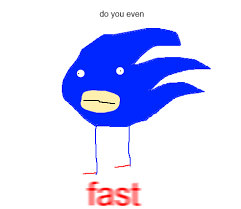

# FastAPI and SQL-Lite Practice

the goal of this practice is to create a project linking fastAPI and sql lite and implement CRUD. the idea is to take the user names, display a message for them. when a usert is added they be given an id starting from 1. afterwards the user name can be edited or deleted accordingly. 

# uvicorn: something called ASGI which is a server to run the FastAPI app

# sqlalchemy: DB ORM (object relational mapping) to run and interact with the sql-lite
 
# nest_asyncio: to run it inside jupyter because it has an event loop of its own

In [1]:
!pip install fastapi uvicorn sqlalchemy nest_asyncio

# Database Setup

importing the required functions from the sqlalcemy. the ones for creating the DB and connecting it to alchemy, initiating the contact, as well as creating the table and cols.

In [2]:
from sqlalchemy import create_engine
from sqlalchemy import Column
from sqlalchemy import Integer
from sqlalchemy import String
from sqlalchemy.orm import declarative_base
from sqlalchemy.orm import sessionmaker

DATABASE_URL = "sqlite:///./LeTest.db" # the sql file that will be saved in the current running dir
engine = create_engine(DATABASE_URL, connect_args={"check_same_thread": False}) # to connect the sql alchemy to the LeTest, thred thingy needed for multi-threded works like FastAPi
SessionLocal = sessionmaker(bind=engine, autoflush=False, autocommit=False) # create the instance session to talk with the LeTest
Base = declarative_base() # create the base class to drefine the DB tables

# Creating the user table for the LeTest which for now only have a name and an ID that is updated with every commit and refresh
class User(Base):
    __tablename__ = "users"
    id = Column(Integer, primary_key=True, index=True) # auto incremenating 
    name = Column(String, nullable=False)

# creates the table if it does not exist already....which is true cuz it was just created. 
Base.metadata.create_all(bind=engine)

# FastAPI

In [3]:
from fastapi import FastAPI # this is to initalise the app
from fastapi import Depends # this allows for auto injection for stuff like the DB session
from fastapi import HTTPException # to return page status like errors or not found
from sqlalchemy.orm import Session

app = FastAPI()

# the bellow function starts the session and yields the endpoint and then finally closses it after the request is done.
# now this is being gone through every time the depends (get_db) is called, the end point get passed each time.

def get_db():
    db = SessionLocal()
    try:
        yield db
    finally:
        db.close()
        
# endpoints creation

# the bellow function is where the insertion of a new user will be. 
# in a field the user will type in a name, the name will be added to the users column, via a string in a query form. then committed and the DB will be refreshed
# after each refresh if a new user is added, an ID will be added to them.
# filly a message will be displayed to them

@app.post("/users/")
def create_user(name: str, db: Session = Depends(get_db)):
    user = User(name=name)
    db.add(user)
    db.commit()
    db.refresh(user)
    return {"message": f"Hello, {user.name}! Your name is stored.", "id": user.id}

# the bellow asks the database for a list of all the users

@app.get("/users/")
def get_all_users(db: Session = Depends(get_db)):
    return db.query(User).all()

# the bellow searches for a user by their ID, if the user is not found then an error will be displayed (👁️👄👁️🎬)

@app.get("/users/{user_id}")
def get_user(user_id: int, db: Session = Depends(get_db)):
    user = db.query(User).get(user_id)
    if not user:
        raise HTTPException(status_code=404, detail="User not found")
    return user

# the bellow searches for the user using their id, then changes the name to an updated one of choice then commit that change. 
# if no user is found throw an error (👁️👄👁️🎬)
# and since the new name will have the place of an older one, when refreshed no new id will be added

@app.put("/users/{user_id}")
def update_user(user_id: int, name: str, db: Session = Depends(get_db)):
    user = db.query(User).get(user_id)
    if not user:
        raise HTTPException(status_code=404, detail="User not found")
    user.name = name
    db.commit()
    return {"message": f"User {user.id} updated to {user.name}"}

# the bellow delets the user of choice by their ID, and....if a user is not found, throw an error (👁️👄👁️🎬)

@app.delete("/users/{user_id}")
def delete_user(user_id: int, db: Session = Depends(get_db)):
    user = db.query(User).get(user_id)
    if not user:
        raise HTTPException(status_code=404, detail="User not found")
    db.delete(user)
    db.commit()
    return {"message": f"User {user.id} deleted"}

# Run the fastAPI in a background thread 

In [ ]:
import threading
import nest_asyncio # allows to be ran within the notebooks own event loop
import uvicorn 

from fastapi import FastAPI

nest_asyncio.apply()

def run():
    uvicorn.run(app, host="127.0.0.1", port=8000) # sstart the session with (host="127.0.0.1", port=8000)

thread = threading.Thread(target=run, daemon=True) # deamon: when the kernal stops, stop the API as well
thread.start()